# 6.4 Sequence processing with convnets

Convolutional Neural Networks (CNN) perform well on computer vision problems precisely because they operate *convolutionally*. They extract features from local input patches and allow for representation modularity and data efficiency. For those same reasons, CNNs are also relevant to sequence processing. Time can be treated as a spatial dimension, just like the height or width of a 2D image.

Certain 1D CNNs can be competitive with RNNs on certain sequence-processing problems, such as audio generation and machine translation.

## 6.4.1 Understanding 1D convolution for sequence data

1D Convolutions extract local 1D patches from sequences, similar to how 2D Convolutions extract 2D patches from images and applies a transformation to every patch.

![patch](images/6_4_1_patch.jpg)

1D Convolution layers can recognize local patterns in a sequence. If a pattern is found at a certain position in a sentence, it can be recognized at a different position. For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus able to learn about word morphology.

## 6.4.2 1D pooling for sequence data

Similar to 2D pooling, which is used to compress image tensors, there exists 1D pooling, which extracts 1D patches (subsequences) from an input and outputting the maximum value (max pooling) or average value (average pooling). 1D pooling reduces the length of 1D inputs.

## 6.4.3 Implementing a 1D convnet

In Keras, the `Conv1D` layer takes input 3D tensors of shape (`samples, time, features`) and returns similarly shaped 3D tensors. 

Let's build a simple two-layer 1D convnet and apply it to the IMDB sentiment classification task we have used in the past.

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# only 10,000 most common
max_features = 10000
man_len = 500

print "Loading data..."
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print len(x_train), 'train sequences'
print len(x_test), 'test sequences'print 'Pad sequences (samples x time)'
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print 'x_train shape:', x_train.shape
print 'x_test shape:', x_test.shape

Loading data...
25000 train sequences
25000 test sequences


In [4]:
# only 10,000 most common
max_features = 10000
max_len = 500

print 'Pad sequences (samples x time)'
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print 'x_train shape:', x_train.shape
print 'x_test shape:', x_test.shape

Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets consist of a stack of `Conv1D` and `MaxPooling1D` layers, ending in either a pooling or `Flatten` layer that converts the 3D outputs to 2D.

Here is an example 1D convnet for the IMDB dataset.

In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 120s - loss: 0.7699 - acc: 0.5308 - val_loss: 0.6819 - val_acc: 0.6014
Epoch 2/10
20000/20000 [==============================] - 115s - loss: 0.6629 - acc: 0.6765 - val_loss: 0.6571 - val_acc: 0.6682
Epoch 3/10
20000/20000 [==============================] - 115s - loss: 0.6119 - acc: 0.7601 - val_loss: 0.5937 - val_acc: 0.7198
Epoch 4/10
20000/20000 [==============================] - 116s - loss: 0.5124 - acc: 0.8136 - val_loss: 0.4891 - val_acc: 0.7854
Epoch 5/10
20000/20000 [==============================] - 136s - loss: 0.4085 - acc: 0.8485 - val_loss: 0.4146 - val_acc: 0.8386
Epoch 6/10
20000/20000 [==============================] - 121s - loss: 0.3453 - acc: 0.8629 - val_loss: 0.3947 - val_acc: 0.8436
Epoch 7/10
20000/20000 [==============================] - 116s - loss: 0.3068 - acc: 0.8587 - val_loss: 0.4063 - val_acc: 0.8224
Epoch 8/10
20000/20000 [========================

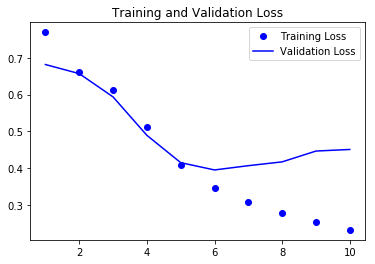

In [7]:
# Draw loss curves for validation and training
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

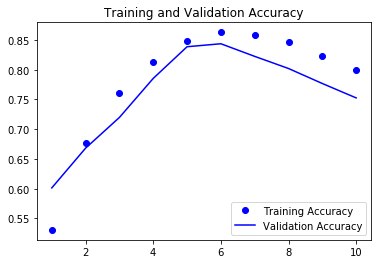

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Our validation accuracy is somewhat less than that of the `LSTM`, but runtime is way faster. This just shows that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment-classification task.

## 6.4.4 Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they aren't sensitive to the order of timesteps, unlike RNNs. Of course, to recognize longer-term patterns, you can stack many convolution layers and pooling layers, resulting in upper layers that will see long chunks of the original inputs—but that’s still a fairly weak way to induce order sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature-forecasting problem, where order-sensitivity is key to producing good predictions. Let's see it in action.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
                              validation_data=val_gen, validation_steps=val_steps)

![jena](images/6_4_4_jena.jpg)

The validation MAE stays over 40%. Yikes. This is because the convnet looks for patterns anywhere in the input timeseries and has no knowledge of the temporal position of pattern it sees (beginning, middle, end, etc.). Because more recent data points should be interpreted differently from older data points, the convnet fails at producing meaningful results. This isn't an issue with the IMDB data, because patterns of keywords associated with a positive or negative sentiment are informative independently of where they're found in the input sentences.

One strategy is to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before an RNN. This is especially useful for dealing with really long sequences. The 1D convnet will turn the long input sequence into a much shorter sequences of higher-level features.

Let's try it on the temperature forecasting dataset!

In [11]:
# Generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [13]:
import os # bring in access to terminal


# folder of data
data_dir = '/Volumes/RobStorage/Desktop/Python_Practice/DL_with_Python/data/jena_climate'
# path to dataset
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# open dataset
f = open(fname)
# read dataset
data = f.read()
# close csv file
f.close()

# formatting
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print header

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [14]:
# import module
import numpy as np

# create NxN-1 Matrix of 0s [420551 rows x 15 - 1 columns]
float_data = np.zeros((len(lines), len(header) - 1))

# add an index. For row, col do this
for i, line in enumerate(lines):
    # convert dtypes to float, split at commas
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [15]:
mean = float_data[:200000].mean(axis=0)

In [16]:
# subtract the mean from float_data
float_data -= mean

In [17]:
# find standard deviation
std = float_data[:200000].std(axis=0)

In [18]:
# divide the float_data by each columns standard deviation
float_data /= std

In [19]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 241s - loss: 0.3397 - val_loss: 0.2846
Epoch 2/20
500/500 [=========================

![jenaloss](images/6_4_4_jenaloss.jpg)

As we see in the validation loss, this setup isn't as good as the regularized `GRU` alone, but significantly faster.

## 6.4.5 Wrapping up

Here are the main take-aways from this section:

 - In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. They offer a faster alternative to RNNs on some problems, in particular natural--language processing tasks.
 - Typically, 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of Conv1D layers and Max-Pooling1D layers, ending in a global pooling operation or flattening operation.
 - Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before an RNN, shortening the sequence and extracting useful representations for the RNN to process.